**Задача:** классификация текстов Шекспира по жанрам

# Загрузка библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import gensim.downloader as downloader # Для скачивания предобученного word2vec

In [4]:
import nltk # Библиотека для работы с текстовыми данными
from nltk import pos_tag # Функция, определяющая часть речи слова
from nltk.corpus import stopwords # Стоп-слова, который нужно удалить из текста
from nltk.tokenize import word_tokenize # Токенизатор, разделяющий текст на отдельные слова
from nltk.stem import WordNetLemmatizer # Лемматизатор - объект, приводящий слово к начальной форме

nltk.download('wordnet') # Загрузка базы данных английских слов, частей речи и т.п. для работы лемматизатора, токенизатора и т.п.
nltk.download('stopwords') # Загрузка набора стоп слов
nltk.download('punkt') # Загрузка данных для токенизатора
nltk.download('averaged_perceptron_tagger') # Инструмент для маркировки частей речи

[nltk_data] Downloading package wordnet to /Users/dimach/nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dimach/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/dimach/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/dimach/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# Загрузка данных

In [44]:
#data = pd.read_csv("filmtv_movies.csv")
data = pd.read_csv("star_wars_reviews.csv")
data

,review_id,fav_heroe,fav_villain,fav_film,fav_soundtrack,fav_spaceship,fav_planet,fav_robot
0,0,Anakin Skywalker,Darth Maul,Episode IV - A New Hope,Accross the Stars,Naboo Starfighter,Tatooine,R2-D2
1,1,Anakin Skywalker,Darth Maul,Episode IV - A New Hope,The Throne Room,Naboo Starfighter,Tatooine,Battle Droid
2,2,Luke Skywalker,Count Dooku,Episode V - The Empire Strikes Back,Star Wars (Main Theme),Millennium Falcon,Endor,R2-D2
3,3,Anakin Skywalker,Wilhuff Tarkin,Episode VI - Return of the Jedi,The Throne Room,Millennium Falcon,Tatooine,R2-D2
4,4,Yoda,Palpatine,Episode IV - A New Hope,Star Wars (Main Theme),Millennium Falcon,Naboo,C-3PO
...,...,...,...,...,...,...,...,...
36922,36922,Obi-Wan Kenobi,Palpatine,Episode VI - Return of the Jedi,Imperial March,Millennium Falcon,Naboo,C-3PO
36923,36923,Han Solo,Darth Vader,Episode VI - Return of the Jedi,Imperial March,Naboo Starfighter,Tatooine,C-3PO
36924,36924,Han Solo,Darth Maul,Episode VI - Return of the Jedi,Imperial March,Millennium Falcon,Alderaan,C-3PO
36925,36925,Anakin Skywalker,Count Dooku,Episode VI - Return of the Jedi,Star Wars (Main Theme),Millennium Falcon,Endor,C-3PO


# Предобработка данных

Удалим все столбцы кроме необходимых для классификации и подготовки данных

In [45]:
#data = data[['title', 'genre', 'country', 'avg_vote', 'description']]
data = data[['fav_heroe', 'fav_villain', 'fav_film', 'fav_soundtrack', 'fav_planet']]

data.dropna()

,fav_heroe,fav_villain,fav_film,fav_soundtrack,fav_planet
0,Anakin Skywalker,Darth Maul,Episode IV - A New Hope,Accross the Stars,Tatooine
1,Anakin Skywalker,Darth Maul,Episode IV - A New Hope,The Throne Room,Tatooine
2,Luke Skywalker,Count Dooku,Episode V - The Empire Strikes Back,Star Wars (Main Theme),Endor
3,Anakin Skywalker,Wilhuff Tarkin,Episode VI - Return of the Jedi,The Throne Room,Tatooine
4,Yoda,Palpatine,Episode IV - A New Hope,Star Wars (Main Theme),Naboo
...,...,...,...,...,...
36922,Obi-Wan Kenobi,Palpatine,Episode VI - Return of the Jedi,Imperial March,Naboo
36923,Han Solo,Darth Vader,Episode VI - Return of the Jedi,Imperial March,Tatooine
36924,Han Solo,Darth Maul,Episode VI - Return of the Jedi,Imperial March,Alderaan
36925,Anakin Skywalker,Count Dooku,Episode VI - Return of the Jedi,Star Wars (Main Theme),Endor


Проверка на наличие пропусков

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36927 entries, 0 to 36926
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   fav_heroe       36927 non-null  object
 1   fav_villain     36927 non-null  object
 2   fav_film        36927 non-null  object
 3   fav_soundtrack  36927 non-null  object
 4   fav_planet      36927 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


Данные устроены следующим образом: пьеса состоит из актов, акты из сцен, сцена из предложений. У каждой пьесы только один жанр.

Классифицировать будем не предложения, а сцены, для сохранения большего контекста.

Сгруппируем данные: все предложения в рамках каждой сцены соберём в одно, сопоставиви каждой сцены жанр пьесы, из которой она взята

In [49]:
plans = data.groupby(['fav_heroe', 'fav_villain', 'fav_film']).agg({
    'fav_planet': 'first'
}).reset_index()


In [51]:
plans.dropna()
plans

,fav_heroe,fav_villain,fav_film,fav_planet
0,Anakin Skywalker,Count Dooku,Episode I - The Phantom Menace,Naboo
1,Anakin Skywalker,Count Dooku,Episode II - Attack of the Clones,Tatooine
2,Anakin Skywalker,Count Dooku,Episode III - Revenge of the Sith,Naboo
3,Anakin Skywalker,Count Dooku,Episode IV - A New Hope,Tatooine
4,Anakin Skywalker,Count Dooku,Episode V - The Empire Strikes Back,Naboo
...,...,...,...,...
319,Yoda,Wilhuff Tarkin,Episode II - Attack of the Clones,Tatooine
320,Yoda,Wilhuff Tarkin,Episode III - Revenge of the Sith,Naboo
321,Yoda,Wilhuff Tarkin,Episode IV - A New Hope,Tatooine
322,Yoda,Wilhuff Tarkin,Episode V - The Empire Strikes Back,Tatooine


[]

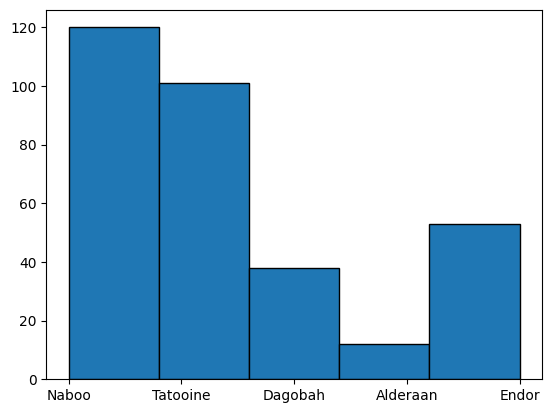

In [53]:
plt.hist(plans['fav_planet'], bins=5,edgecolor='black')
plt.plot()

In [54]:
Lemmatizer = WordNetLemmatizer()

def lemmatizer_tag(word): # Получение части речи в формате, который требует лемматизатор
  tag = pos_tag([word])[0][1][0].upper()
  tag_dict = {
      "J": "a",  # Прилагательное
      "N": "n",  # Существительное
      "R": "r",  # Наречие
      "V": "v",  # Глагол
    }
  return tag_dict.get(tag, "n")

def clean_text(text, normalization=False):
  text = text.lower() # Приведение к нижнему регистру
  words = word_tokenize(text) # Токенизация
  no_stop_words = [word for word in words if word not in set(stopwords.words('english')) and word.isalpha()] # Удаление стоп-слов и не-слов (цифр, спец знаков и т.п.)
  if normalization: # Лемматизация (метод нормализации) происходит, если того требует пользователь
    cleaned_words = [Lemmatizer.lemmatize(word, lemmatizer_tag(word)) for word in no_stop_words]
    return ' '.join(cleaned_words)
  return ' '.join(no_stop_words)

In [55]:
plans["clear_films"] = plans['fav_film'].apply(clean_text)
plans["normalized_films"] = plans['fav_film'].apply(lambda x: clean_text(x, True))
plans

,fav_heroe,fav_villain,fav_film,fav_planet,clear_films,normalized_films
0,Anakin Skywalker,Count Dooku,Episode I - The Phantom Menace,Naboo,episode phantom menace,episode phantom menace
1,Anakin Skywalker,Count Dooku,Episode II - Attack of the Clones,Tatooine,episode ii attack clones,episode ii attack clone
2,Anakin Skywalker,Count Dooku,Episode III - Revenge of the Sith,Naboo,episode iii revenge sith,episode iii revenge sith
3,Anakin Skywalker,Count Dooku,Episode IV - A New Hope,Tatooine,episode iv new hope,episode iv new hope
4,Anakin Skywalker,Count Dooku,Episode V - The Empire Strikes Back,Naboo,episode v empire strikes back,episode v empire strike back
...,...,...,...,...,...,...
319,Yoda,Wilhuff Tarkin,Episode II - Attack of the Clones,Tatooine,episode ii attack clones,episode ii attack clone
320,Yoda,Wilhuff Tarkin,Episode III - Revenge of the Sith,Naboo,episode iii revenge sith,episode iii revenge sith
321,Yoda,Wilhuff Tarkin,Episode IV - A New Hope,Tatooine,episode iv new hope,episode iv new hope
322,Yoda,Wilhuff Tarkin,Episode V - The Empire Strikes Back,Tatooine,episode v empire strikes back,episode v empire strike back


In [56]:
plans["class"] = plans["fav_planet"].replace({
    "Naboo": 0,
    "Tatooine": 1,
    "Endor": 2,
    "Dagobah": 3,
    "Alderaan": 4
})

# Классификация

Функция для создания датасета к нейронной сети с помощью векторизаторов

In [66]:
def create_datasets_with_vectorizer(x, y, vectorizer, random_state=0):
  y = np.array(y)
  x_train, x_test, y_train, y_test = train_test_split(
      x,
      y,
      test_size=0.2,
      stratify=y,
      random_state=random_state
  )
  x_train = vectorizer.fit_transform(x_train).toarray()
  x_test = vectorizer.transform(x_test).toarray()
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train)
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test)
  train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
  test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
  return (
      DataLoader(train_dataset, batch_size=10, shuffle=True),
      DataLoader(test_dataset, batch_size=10),
      len(vectorizer.vocabulary_) #Размерность словаря, для определения размера входного слоя нейронной сети
  )

Тестирование модели

In [67]:
def test_model(train, test, model, epochs=10):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()
  for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for inputs, labels in train:
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      running_loss += loss.item()
      loss.backward()
      optimizer.step()
    print(f"Эпоха: {epoch+1}, ошибка на обучении: {running_loss/len(train)}")
    running_loss = 0.0
    model.eval()
    with torch.no_grad():
      for inputs, labels in test:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
    print(f"На валидации: {running_loss/len(test)}")

Классификатор

In [68]:
class TextClassifier(nn.Module):
  def __init__(self, num_features):
    super(TextClassifier, self).__init__()
    self.fc1 = nn.Linear(num_features, 50)
    self.fc2 = nn.Linear(50, 20)
    self.fc3 = nn.Linear(20, 5)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    return self.fc3(x)

Метод "Мешок слов" (реализуется в CountVectorizer)

In [69]:
train, test, voc_size = create_datasets_with_vectorizer(plans['clear_films'], plans["class"], CountVectorizer()) # Тестирование на очищенных данных
test_model(train, test, TextClassifier(voc_size))

Эпоха: 1, ошибка на обучении: 1.5859317687841563
На валидации: 1.5669975280761719
Эпоха: 2, ошибка на обучении: 1.4957308494127715
На валидации: 1.4996410778590612
Эпоха: 3, ошибка на обучении: 1.427136045235854
На валидации: 1.4725708620888847
Эпоха: 4, ошибка на обучении: 1.406440964111915
На валидации: 1.4634608711515154
Эпоха: 5, ошибка на обучении: 1.3927172376559331
На валидации: 1.4601410797664098
Эпоха: 6, ошибка на обучении: 1.3887132222835834
На валидации: 1.4637611082621984
Эпоха: 7, ошибка на обучении: 1.3850734784052923
На валидации: 1.46115699836186
Эпоха: 8, ошибка на обучении: 1.382911544579726
На валидации: 1.464701771736145
Эпоха: 9, ошибка на обучении: 1.3802403074044447
На валидации: 1.465995499065944
Эпоха: 10, ошибка на обучении: 1.3784752167188203
На валидации: 1.4687264817101615


In [70]:
train, test, voc_size = create_datasets_with_vectorizer(plans['normalized_films'], plans["class"], CountVectorizer()) #Тестирование на очищенных и нормализованных данных
test_model(train, test, TextClassifier(voc_size))

Эпоха: 1, ошибка на обучении: 1.5484832387704115
На валидации: 1.5287689992359705
Эпоха: 2, ошибка на обучении: 1.4971987926042998
На валидации: 1.492613366671971
Эпоха: 3, ошибка на обучении: 1.4547097912201514
На валидации: 1.4665222678865706
Эпоха: 4, ошибка на обучении: 1.4230666435681856
На валидации: 1.4531637941087996
Эпоха: 5, ошибка на обучении: 1.4081540199426503
На валидации: 1.4470750434058053
Эпоха: 6, ошибка на обучении: 1.3965424024141753
На валидации: 1.4506395714623588
Эпоха: 7, ошибка на обучении: 1.3899580194399908
На валидации: 1.4514832156045097
Эпоха: 8, ошибка на обучении: 1.3871073172642634
На валидации: 1.4551525967461723
Эпоха: 9, ошибка на обучении: 1.3854009600786061
На валидации: 1.4563091823032923
Эпоха: 10, ошибка на обучении: 1.380328357219696
На валидации: 1.4588343756539481


Метод Tf-Idf (реализуется в TfidfVectorizer)

In [71]:
train, test, voc_size = create_datasets_with_vectorizer(plans['clear_films'], plans["class"], TfidfVectorizer()) # Тестирование на очищенных данных
test_model(train, test, TextClassifier(voc_size))

Эпоха: 1, ошибка на обучении: 1.6424564673350408
На валидации: 1.6161783593041557
Эпоха: 2, ошибка на обучении: 1.5995883574852576
На валидации: 1.5762406928198678
Эпоха: 3, ошибка на обучении: 1.546370987708752
На валидации: 1.5230567966188704
Эпоха: 4, ошибка на обучении: 1.4774121642112732
На валидации: 1.4608744553157262
Эпоха: 5, ошибка на обучении: 1.4163914506251996
На валидации: 1.4384690523147583
Эпоха: 6, ошибка на обучении: 1.3975766805502086
На валидации: 1.4380897624152047
Эпоха: 7, ошибка на обучении: 1.3933159342178931
На валидации: 1.4386225427900041
Эпоха: 8, ошибка на обучении: 1.390900689821977
На валидации: 1.436199460710798
Эпоха: 9, ошибка на обучении: 1.3897932080122142
На валидации: 1.4374086516244071
Эпоха: 10, ошибка на обучении: 1.3892268171677222
На валидации: 1.4379921640668596


In [72]:
train, test, voc_size = create_datasets_with_vectorizer(plans['normalized_films'], plans["class"], TfidfVectorizer()) #Тестирование на очищенных и нормализованных данных
test_model(train, test, TextClassifier(voc_size))

Эпоха: 1, ошибка на обучении: 1.607845324736375
На валидации: 1.5928984880447388
Эпоха: 2, ошибка на обучении: 1.56541403898826
На валидации: 1.5488711425236292
Эпоха: 3, ошибка на обучении: 1.5098209977149963
На валидации: 1.4976715019771032
Эпоха: 4, ошибка на обучении: 1.4481455592008738
На валидации: 1.4502586126327515
Эпоха: 5, ошибка на обучении: 1.405145255418924
На валидации: 1.4372154985155379
Эпоха: 6, ошибка на обучении: 1.3947400129758394
На валидации: 1.4356436729431152
Эпоха: 7, ошибка на обучении: 1.390011021724114
На валидации: 1.4368542432785034
Эпоха: 8, ошибка на обучении: 1.3855045988009527
На валидации: 1.437834586415972
Эпоха: 9, ошибка на обучении: 1.3826219760454619
На валидации: 1.4394733224596297
Эпоха: 10, ошибка на обучении: 1.3800642169438875
На валидации: 1.439854451588222


Word2Vec

Загрузка предварительно обученной модели

In [73]:
w2v = downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


Функция для конвертации предложения в вектор векторов слов

In [74]:
def text_to_vectors(text, model, max_len):
    words = text.split()
    words = words[:max_len] + ['<pad>'] * (max_len - len(words))
    vectors = []
    for word in words:
        if word in model:
            vectors.append(model[word])
        else:
            vectors.append(np.zeros(model.vector_size))
    return vectors

Длины текстов

In [75]:
plans['clear_films'].apply(lambda x: len(x.split())).median() # Медиана длины текста

4.0

Создание датасетов

In [76]:
def create_datasets_with_word2vec(x, y, model, random_state=0):
  y = np.array(y)
  x_train, x_test, y_train, y_test = train_test_split(
      x,
      y,
      test_size=0.2,
      stratify=y,
      random_state=random_state
  )
  x_train_vec = x_train.apply(lambda x: text_to_vectors(x, model, 404))
  x_test_vec = x_test.apply(lambda x: text_to_vectors(x, model, 404))
  x_train_tensor = torch.tensor(x_train_vec.tolist(), dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train)
  x_test_tensor = torch.tensor(x_test_vec.tolist(), dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test)
  train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
  test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
  return (
      DataLoader(train_dataset, batch_size=10, shuffle=True),
      DataLoader(test_dataset, batch_size=10)
  )

LSTM нейронная сеть

In [77]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        last_hidden = hidden[-1]
        out = self.fc(last_hidden)
        return out

Проверка модели на очищенных данных

In [79]:
train, test = create_datasets_with_word2vec(plans['clear_films'], plans['class'], w2v)
test_model(train, test, LSTMClassifier(300, 50, 5))

Эпоха: 1, ошибка на обучении: 1.5931709958956792
На валидации: 1.5424227373940604
Эпоха: 2, ошибка на обучении: 1.4638380362437322
На валидации: 1.4356921400342668
Эпоха: 3, ошибка на обучении: 1.4187857600358815
На валидации: 1.420730539730617
Эпоха: 4, ошибка на обучении: 1.4104001751312842
На валидации: 1.4198500258581979
Эпоха: 5, ошибка на обучении: 1.4110383024582496
На валидации: 1.4133495092391968
Эпоха: 6, ошибка на обучении: 1.4121966041051424
На валидации: 1.4141594341823034
Эпоха: 7, ошибка на обучении: 1.409495119865124
На валидации: 1.4171392577035087
Эпоха: 8, ошибка на обучении: 1.4134884339112501
На валидации: 1.4153741257531303
Эпоха: 9, ошибка на обучении: 1.4058311352363
На валидации: 1.4132242713655745
Эпоха: 10, ошибка на обучении: 1.4090345593599172
На валидации: 1.4146530628204346


In [80]:
train, test = create_datasets_with_word2vec(plans['normalized_films'], plans['class'], w2v)
test_model(train, test, LSTMClassifier(300, 50, 5))

Эпоха: 1, ошибка на обучении: 1.5909861830564647
На валидации: 1.5421592167445592
Эпоха: 2, ошибка на обучении: 1.4656967199765718
На валидации: 1.4384157317025321
Эпоха: 3, ошибка на обучении: 1.4116374024978051
На валидации: 1.4213038342339652
Эпоха: 4, ошибка на обучении: 1.4128579497337341
На валидации: 1.4150992121015276
Эпоха: 5, ошибка на обучении: 1.412844786277184
На валидации: 1.4114333050591605
Эпоха: 6, ошибка на обучении: 1.407058807519766
На валидации: 1.4129458495548792
Эпоха: 7, ошибка на обучении: 1.4111192730756907
На валидации: 1.4131899561200822
Эпоха: 8, ошибка на обучении: 1.4108228454223046
На валидации: 1.4145140647888184
Эпоха: 9, ошибка на обучении: 1.4045625787514906
На валидации: 1.4132608004978724
Эпоха: 10, ошибка на обучении: 1.4045449770413911
На валидации: 1.4152832542146956
